In [ ]:
import os
import numpy as np
import pydicom
import nibabel as nib

def load_dicom_series(dicom_folder):
    dicom_files = sorted([
        pydicom.dcmread(os.path.join(dicom_folder, f))
        for f in os.listdir(dicom_folder)
        if f.endswith(".dcm")
    ], key=lambda d: int(d.InstanceNumber))
    
    slices = [d.pixel_array for d in dicom_files]
    volume = np.stack(slices, axis=-1)  # shape: (H, W, D)
    
    # spacing (PixelSpacing[0], PixelSpacing[1], SliceThickness)
    spacing = (
        float(dicom_files[0].PixelSpacing[0]),
        float(dicom_files[0].PixelSpacing[1]),
        float(dicom_files[0].SliceThickness)
    )
    
    affine = np.diag(spacing + (1.0,))  # 4x4 affine matrix
    
    return volume, affine

dicom_folder = '../../data/stroke_2023/1.Training/1.원천데이터/0100.Ischemic Stroke'
volume, affine = load_dicom_series(dicom_folder)

nii_img = nib.Nifti1Image(volume, affine)
nib.save(nii_img, 'output_brain.nii.gz')

Data type: float64
Min: -1.0 Max: 0.9999998807907104


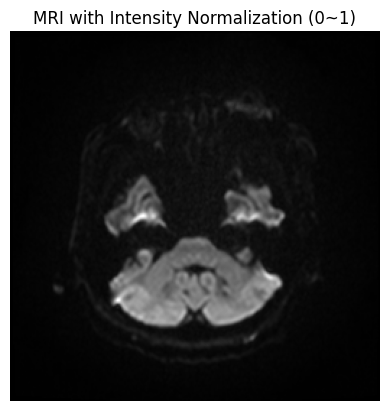

In [18]:
import pydicom
import numpy as np
import cv2
from matplotlib import pyplot as plt

# 1. DICOM 파일 불러오기
dcm_path = "../../data/stroke_2023/1.Training/1.원천데이터/0100.Ischemic Stroke/0130.MR Diffusion/ANO1_0001_Ischemic Stroke_MRI_DWI_018.dcm"
dcm = pydicom.dcmread(dcm_path)

# 픽셀 데이터 가져오기
img = dcm.pixel_array.astype(np.float32)

# 2. 정규화 (0~1 사이로)
img_norm = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

# 시각화
plt.imshow(img_norm, cmap='gray')
plt.title("MRI with Intensity Normalization (0~1)")
plt.axis('off')
plt.show()

In [1]:
import os
import numpy as np
import pydicom
import nibabel as nib
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
import med_ddpm.dataset as dataset
from torchvision.transforms import Compose, ToTensor, Lambda
import torch
img = nib.load('../../data/stroke_mri_nii/images/ANO1_0001.nii.gz').get_fdata()
transform = Compose([
    Lambda(lambda t: torch.tensor(t).float()),
    Lambda(lambda t: (t * 2) - 1),
    Lambda(lambda t: t.unsqueeze(0)),
    Lambda(lambda t: t.transpose(3, 1)),
])

input_transform = Compose([
    Lambda(lambda t: torch.tensor(t).float()),
    Lambda(lambda t: (t * 2) - 1),
    Lambda(lambda t: t.permute(3, 0, 1, 2)),
    Lambda(lambda t: t.transpose(3, 1)),
])

dataset = dataset.NiftiPairImageGenerator(
        '../../data/stroke_mri_nii/masks/',
        '../../data/stroke_mri_nii/images/',
        input_size=128,
        depth_size=64,
        transform=input_transform,
        target_transform=transform,
        full_channel_mask=True
    )


ModuleNotFoundError: No module named 'utils'

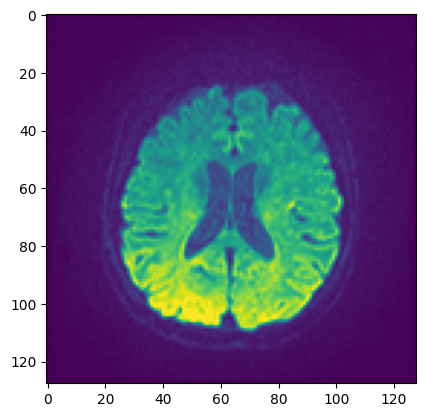

In [38]:
plt.imshow(img[30])